# Análise de Séries Temporais
## Comparação entre os Modelos Holt-Winters e SARIMA

**Dados:** Consumo Residencial de Energia por Unidade Federativa (Brasil)

---

## Objetivo

Avaliar o desempenho preditivo dos modelos Holt-Winters e SARIMA aplicados à série temporal de consumo de energia elétrica residencial, utilizando as métricas RMSE, MAE e MAPE.

---
### Modelo Holt-Winters

**Forma Aditiva:**
$$\hat{y}_{t+h} = L_t + hT_t + S_{t-s+h}$$

**Forma Multiplicativa:**
$$\hat{y}_{t+h} = (L_t + hT_t) \times S_{t-s+h}$$

### Modelo SARIMA(p,d,q)(P,D,Q)s

$$\Phi_P(B^s)\phi(B)(1-B)^d(1-B^s)^D y_t = \Theta_Q(B^s)\theta(B)\varepsilon_t$$

---

### Métricas de Avaliação

| Métrica | Fórmula | Interpretação |
|---------|---------|---------------|
| RMSE | $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$ | Raiz do erro quadrático médio |
| MAE | $\frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$ | Erro absoluto médio |
| MAPE | $\frac{100\%}{n}\sum_{i=1}^{n}\left|\frac{y_i - \hat{y}_i}{y_i}\right|$ | Erro percentual absoluto médio |

## 1. Carregamento dos Dados

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

In [19]:
arquivo = 'CONSUMO RESIDENCIAL  DE ENERGIA POR UF.xlsx'
df = pd.read_excel(arquivo, skiprows=0)

In [20]:
df.head()

,Unnamed: 0,2004,2004.1,2004.2,2004.3,2004.4,2004.5,2004.6,2004.7,2004.8,...,2025*.2,2025*.3,2025*.4,2025*.5,2025*.6,2025*.7,2025*.8,2025*.9,2025*.10,2025*.11
0,UF,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,...,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ
1,Brasil,26978361.463,26508269.295,27284337.172,28046181.323,27248156.753,27082960.944,27346004.948,27656857.938,28282497.483,...,49235826.448,47025029.798,46671397.403,45088257.533,45303092.973,NaN,NaN,NaN,NaN,NaN
2,Rondonia,112812,105806,106668,107580,112115.8,107816.5,108589,110858,116058,...,320867.166,315792.079,348982.113,332276.27,326423.302,NaN,NaN,NaN,NaN,NaN
3,Acre,34840.033,33050.335,33858.038,34961.023,33416.604,32048.595,33659.693,34837.451,36879.798,...,105435.139,106820.097,113776.736,106044.292,98664.58,NaN,NaN,NaN,NaN,NaN
4,Amazonas,274773,278429.715,270420,279044.699,283866,285251,295884,296649.546,308616.486,...,625800,637535,674173,647103,676595,NaN,NaN,NaN,NaN,NaN


In [21]:
df.isnull().sum().sum()

np.int64(140)

## 2. Pré-processamento dos Dados

In [22]:
df_transposto = df.set_index(df.columns[0]).T
print(df_transposto.head())

Unnamed: 0   UF        Brasil  Rondonia       Acre    Amazonas    Roraima  \
2004        JAN  26978361.463    112812  34840.033      274773  31695.624   
2004.1      FEV  26508269.295    105806  33050.335  278429.715  30802.288   
2004.2      MAR  27284337.172    106668  33858.038      270420  30275.526   
2004.3      ABR  28046181.323    107580  34961.023  279044.699   33035.03   
2004.4      MAI  27248156.753  112115.8  33416.604      283866  28944.364   

Unnamed: 0         Para  Amapa  Tocantins    Maranhao  ... Espirito Santo  \
2004        1011353.052  43084  65876.607  737033.285  ...     607655.057   
2004.1        967109.32  28944  63306.912  694591.783  ...     583260.096   
2004.2      1022952.837  42451  67551.247  743086.198  ...     599524.936   
2004.3      1032232.985  40234  71774.323  728379.037  ...     583307.113   
2004.4      1057805.507  38522   74458.77  751060.141  ...     586400.763   

Unnamed: 0 Rio de Janeiro    Sao Paulo       Parana Santa Catarina  \
2004

In [23]:
# Usar o dataframe transposto
df_limpo = df_transposto.copy()

# Remover a linha 'UF' (primeiro registro)
df_limpo = df_limpo[df_limpo.iloc[:, 0] != 'UF']

# Criar índice temporal a partir do índice e da coluna 'UF' (que contém o mês)
meses_map = {'JAN': 1, 'FEV': 2, 'MAR': 3, 'ABR': 4, 'MAI': 5, 'JUN': 6,
             'JUL': 7, 'AGO': 8, 'SET': 9, 'OUT': 10, 'NOV': 11, 'DEZ': 12}

# Criar lista de datas
datas = []
for idx, mes_str in zip(df_limpo.index, df_limpo.iloc[:, 0]):
    try:
        # Extrair ano (pega só a parte inteira do float ou antes do ponto)
        ano_str = str(idx).split('.')[0].replace('*', '').strip()
        ano = int(ano_str)
        mes = meses_map.get(mes_str, 1)
        datas.append(pd.Timestamp(year=ano, month=mes, day=1))
    except:
        datas.append(pd.NaT)

df_limpo.index = pd.DatetimeIndex(datas)
df_limpo = df_limpo[df_limpo.index.notna()]

# Pegar apenas as colunas numéricas (estados), excluindo a primeira que é o mês
colunas_estados = df_limpo.columns[1:]

# Garantir que os valores são numéricos
for col in colunas_estados:
    df_limpo[col] = pd.to_numeric(df_limpo[col], errors='coerce')

# Calcular o total (Brasil já está na segunda coluna)
ts_total = df_limpo['Brasil']
ts_total = pd.to_numeric(ts_total, errors='coerce').dropna()
ts_total.name = 'Consumo Total'

print(f"Período: {ts_total.index[0].strftime('%b/%Y')} a {ts_total.index[-1].strftime('%b/%Y')}")
print(f"Observações: {len(ts_total)}")

Período: jan/2004 a jul/2025
Observações: 259


In [24]:
ts_total.describe()

count    2.590000e+02
mean     3.739789e+07
std      5.364679e+06
min      2.650827e+07
25%      3.284024e+07
50%      3.837170e+07
75%      4.095145e+07
max      4.923583e+07
Name: Consumo Total, dtype: float64

## 3. Análise Exploratória e Decomposição

A decomposição da série temporal permite identificar seus componentes:

| Componente | Descrição |
|------------|-----------|
| Tendência ($T_t$) | Movimento de longo prazo |
| Sazonalidade ($S_t$) | Padrão repetitivo em períodos fixos |
| Resíduo ($\varepsilon_t$) | Variação aleatória |

**Modelo Aditivo:** $y_t = T_t + S_t + \varepsilon_t$

**Modelo Multiplicativo:** $y_t = T_t \times S_t \times \varepsilon_t$

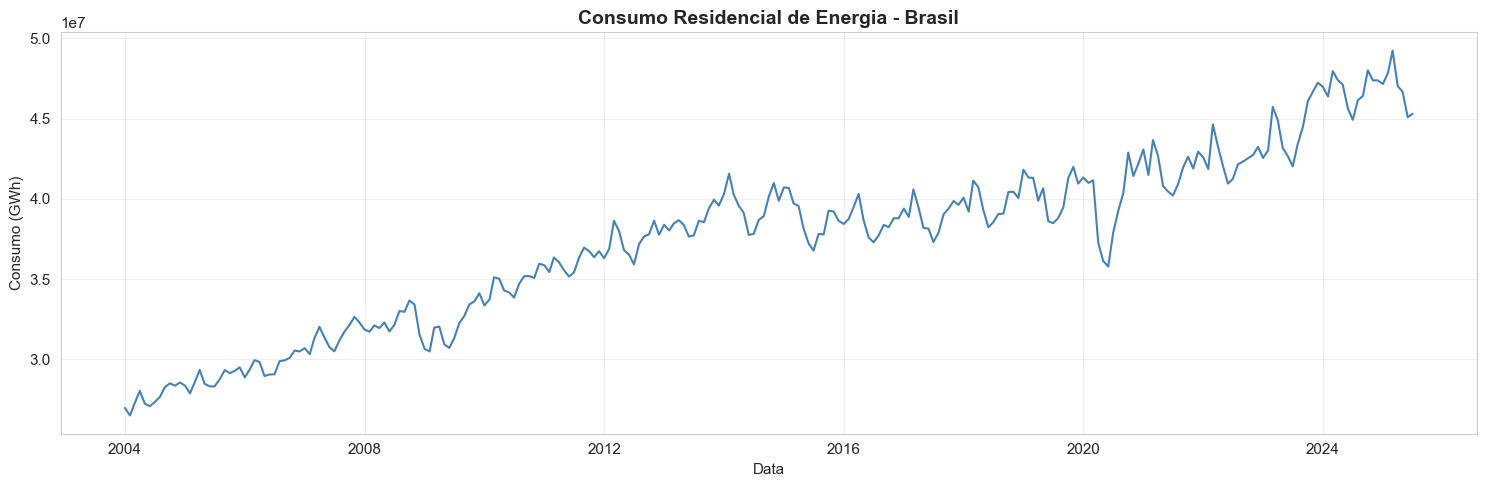

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(ts_total.index, ts_total.values, linewidth=1.5, color='steelblue')
plt.title('Consumo Residencial de Energia - Brasil', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Consumo (GWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

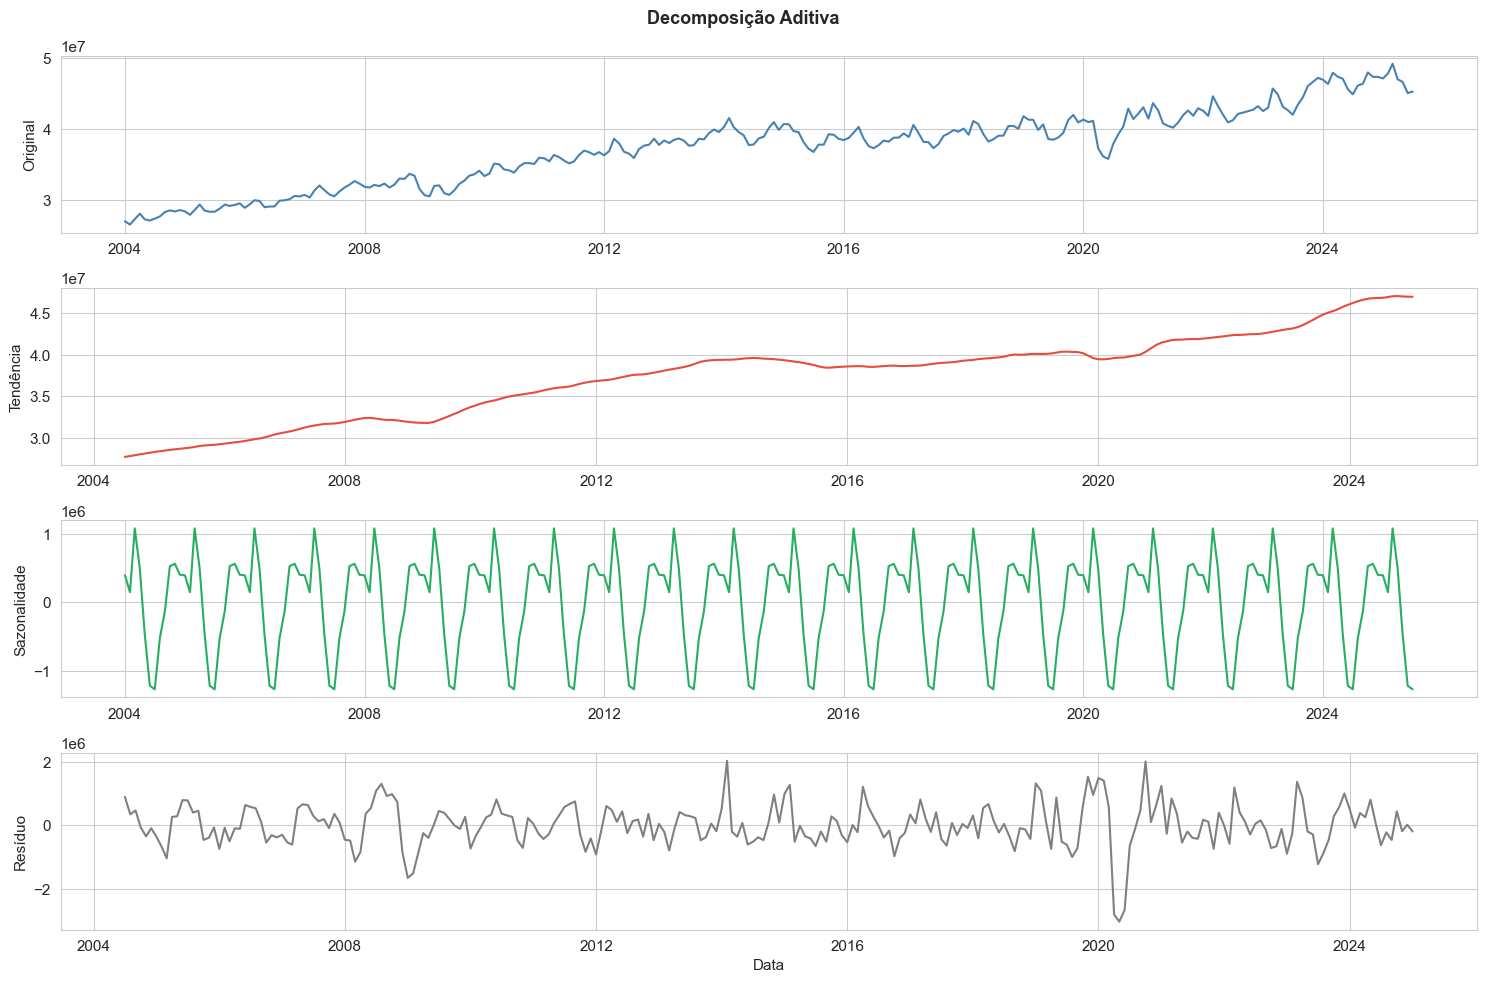

In [26]:
periodo_sazonal = 12
decomp_add = seasonal_decompose(ts_total, model='additive', period=periodo_sazonal)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Decomposição Aditiva', fontsize=13, fontweight='bold')

axes[0].plot(ts_total, color='steelblue')
axes[0].set_ylabel('Original')

axes[1].plot(decomp_add.trend, color='#e74c3c')
axes[1].set_ylabel('Tendência')

axes[2].plot(decomp_add.seasonal, color='#27ae60')
axes[2].set_ylabel('Sazonalidade')

axes[3].plot(decomp_add.resid, color='gray')
axes[3].set_ylabel('Resíduo')
axes[3].set_xlabel('Data')

plt.tight_layout()
plt.show()

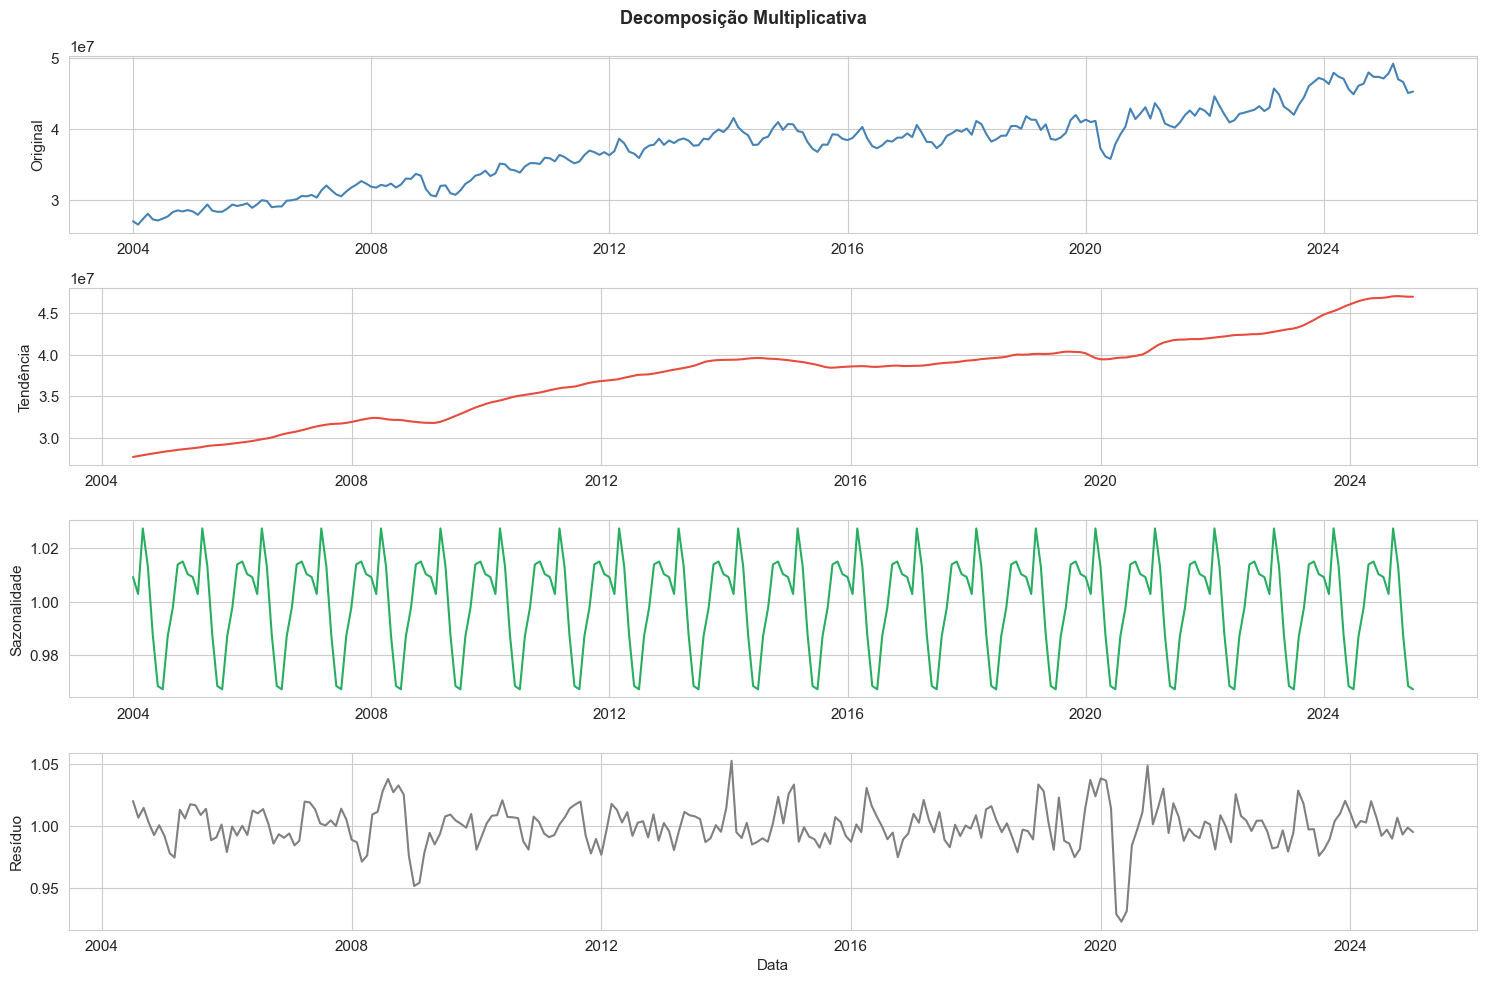

In [27]:
decomp_mult = seasonal_decompose(ts_total, model='multiplicative', period=periodo_sazonal)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Decomposição Multiplicativa', fontsize=13, fontweight='bold')

axes[0].plot(ts_total, color='steelblue')
axes[0].set_ylabel('Original')

axes[1].plot(decomp_mult.trend, color='#e74c3c')
axes[1].set_ylabel('Tendência')

axes[2].plot(decomp_mult.seasonal, color='#27ae60')
axes[2].set_ylabel('Sazonalidade')

axes[3].plot(decomp_mult.resid, color='gray')
axes[3].set_ylabel('Resíduo')
axes[3].set_xlabel('Data')

plt.tight_layout()
plt.show()

## 4. Teste de Estacionariedade (ADF)

O teste Augmented Dickey-Fuller (ADF) verifica a presença de raiz unitária na série:

- $H_0$: A série possui raiz unitária (não estacionária)
- $H_1$: A série é estacionária

Critério de decisão: rejeita-se $H_0$ se p-valor < 0.05.

In [28]:
def teste_adf(serie, nome):
    """Realiza o teste ADF e retorna se a série é estacionária."""
    resultado = adfuller(serie.dropna(), autolag='AIC')
    p_valor = resultado[1]
    
    print(f"Teste ADF - {nome}")
    print(f"Estatística ADF: {resultado[0]:.4f}")
    print(f"p-valor: {p_valor:.6f}")
    print(f"Resultado: {'Estacionária' if p_valor <= 0.05 else 'Não estacionária'}\n")
    
    return p_valor <= 0.05

estacionaria = teste_adf(ts_total, "Série Original")

Teste ADF - Série Original
Estatística ADF: -0.5273
p-valor: 0.886584
Resultado: Não estacionária



In [29]:
if not estacionaria:
    serie_diff = ts_total.diff().dropna()
    estacionaria_diff = teste_adf(serie_diff, "Série Diferenciada (d=1)")
    
    if estacionaria_diff:
        d_value = 1
    else:
        serie_diff2 = serie_diff.diff().dropna()
        teste_adf(serie_diff2, "Série Diferenciada (d=2)")
        d_value = 2
else:
    d_value = 0

print(f"Parâmetro d recomendado: {d_value}")

Teste ADF - Série Diferenciada (d=1)
Estatística ADF: -4.5739
p-valor: 0.000144
Resultado: Estacionária

Parâmetro d recomendado: 1


## 5. Análise das Funções de Autocorrelação

As funções ACF e PACF auxiliam na identificação dos parâmetros do modelo SARIMA:

| Função | Parâmetro identificado |
|--------|------------------------|
| ACF | q (MA) e Q (MA sazonal) |
| PACF | p (AR) e P (AR sazonal) |

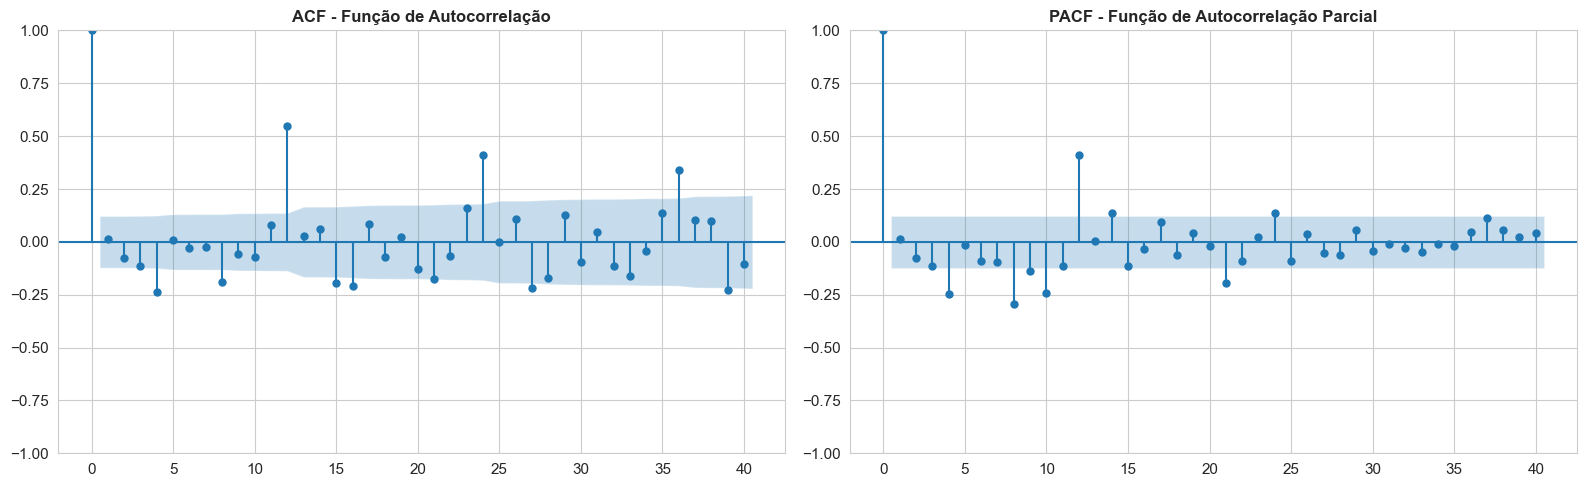

In [30]:
ts_analise = ts_total.diff().dropna() if d_value > 0 else ts_total

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(ts_analise, lags=40, ax=axes[0])
axes[0].set_title('ACF - Função de Autocorrelação', fontsize=12, fontweight='bold')

plot_pacf(ts_analise, lags=40, ax=axes[1])
axes[1].set_title('PACF - Função de Autocorrelação Parcial', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Modelagem SARIMA

O modelo SARIMA(p, d, q)(P, D, Q)s é definido por:

$$\Phi_P(B^s)\phi(B)(1 - B)^d(1 - B^s)^D y_t = \Theta_Q(B^s)\theta(B)\varepsilon_t$$

Onde:
- $\phi(B) = 1 - \phi_1 B - ... - \phi_p B^p$ (componente AR)
- $\theta(B) = 1 + \theta_1 B + ... + \theta_q B^q$ (componente MA)
- $\Phi_P(B^s)$, $\Theta_Q(B^s)$: componentes sazonais
- $s$: período sazonal

A seleção do modelo é realizada via critério AIC (Akaike Information Criterion).

In [31]:
# Divisão dos dados: 80% treino, 20% teste
tamanho_treino = int(len(ts_total) * 0.8)
treino = ts_total[:tamanho_treino]
teste = ts_total[tamanho_treino:]

print(f"Treino: {len(treino)} observações")
print(f"Teste: {len(teste)} observações")

Treino: 207 observações
Teste: 52 observações


In [32]:
# Busca dos melhores parâmetros SARIMA via grid search
s = 12  # Período sazonal

best_aic = np.inf
best_params = None
best_seasonal = None
resultados = []

for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            for P in range(0, 2):
                for D in range(0, 2):
                    for Q in range(0, 2):
                        try:
                            modelo = SARIMAX(treino, 
                                           order=(p, d, q), 
                                           seasonal_order=(P, D, Q, s),
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
                            resultado = modelo.fit(disp=False)
                            
                            if resultado.aic < best_aic:
                                best_aic = resultado.aic
                                best_params = (p, d, q)
                                best_seasonal = (P, D, Q, s)
                            
                            resultados.append({
                                'Ordem': f"({p},{d},{q})",
                                'Sazonal': f"({P},{D},{Q},{s})",
                                'AIC': resultado.aic,
                                'BIC': resultado.bic
                            })
                        except:
                            continue

print(f"Melhor modelo: SARIMA{best_params}{best_seasonal}")
print(f"AIC: {best_aic:.2f}")

c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas Mazagão\A

Melhor modelo: SARIMA(0, 1, 2)(1, 1, 1, 12)
AIC: 5359.68


c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [33]:
df_resultados = pd.DataFrame(resultados).sort_values('AIC').head(10)
df_resultados

,Ordem,Sazonal,AIC,BIC
47,"(0,1,2)","(1,1,1,12)",5359.679333,5375.616262
43,"(0,1,2)","(0,1,1,12)",5361.073080,5373.822623
95,"(1,1,2)","(1,1,1,12)",5361.510867,5380.635182
143,"(2,1,2)","(1,1,1,12)",5363.020690,5385.332391
91,"(1,1,2)","(0,1,1,12)",5363.053671,5378.990600
139,"(2,1,2)","(0,1,1,12)",5364.204036,5383.328351
71,"(1,0,2)","(1,1,1,12)",5387.124107,5406.281848
119,"(2,0,2)","(1,1,1,12)",5388.058247,5410.408945
67,"(1,0,2)","(0,1,1,12)",5389.176046,5405.140830
127,"(2,1,0)","(1,1,1,12)",5390.274251,5406.239035


In [34]:
# Ajuste do modelo SARIMA final
modelo_sarima = SARIMAX(treino, 
                        order=best_params, 
                        seasonal_order=best_seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarima_fit = modelo_sarima.fit(disp=False)
sarima_fit.summary()

c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Consumo Total   No. Observations:                  207
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -2674.840
Date:                              qui, 11 dez 2025   AIC                           5359.679
Time:                                      16:18:37   BIC                           5375.616
Sample:                                  01-01-2004   HQIC                          5366.142
                                       - 03-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1263      0.067     -1.885      0.059      -0.258       0.005
ma.L2         -0.2322      0.071     -3.253      0.001      -0.372      -0.092
ar.S.L12      -0.2646      0.157     -1.682      0.093      -0.573       0.044
ma.S.L12      -0.1594      0.136     -1.177      0.239      -0.425       0.106
sigma2      6.313e+11   1.48e-13   4.28e+24      0.000    6.31e+11    6.31e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 9.78
Prob(Q):                              0.86   Prob(JB):                         0.01
Heteroskedasticity (H):               2.93   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.88e+40. Standard errors may be unstable.
"""

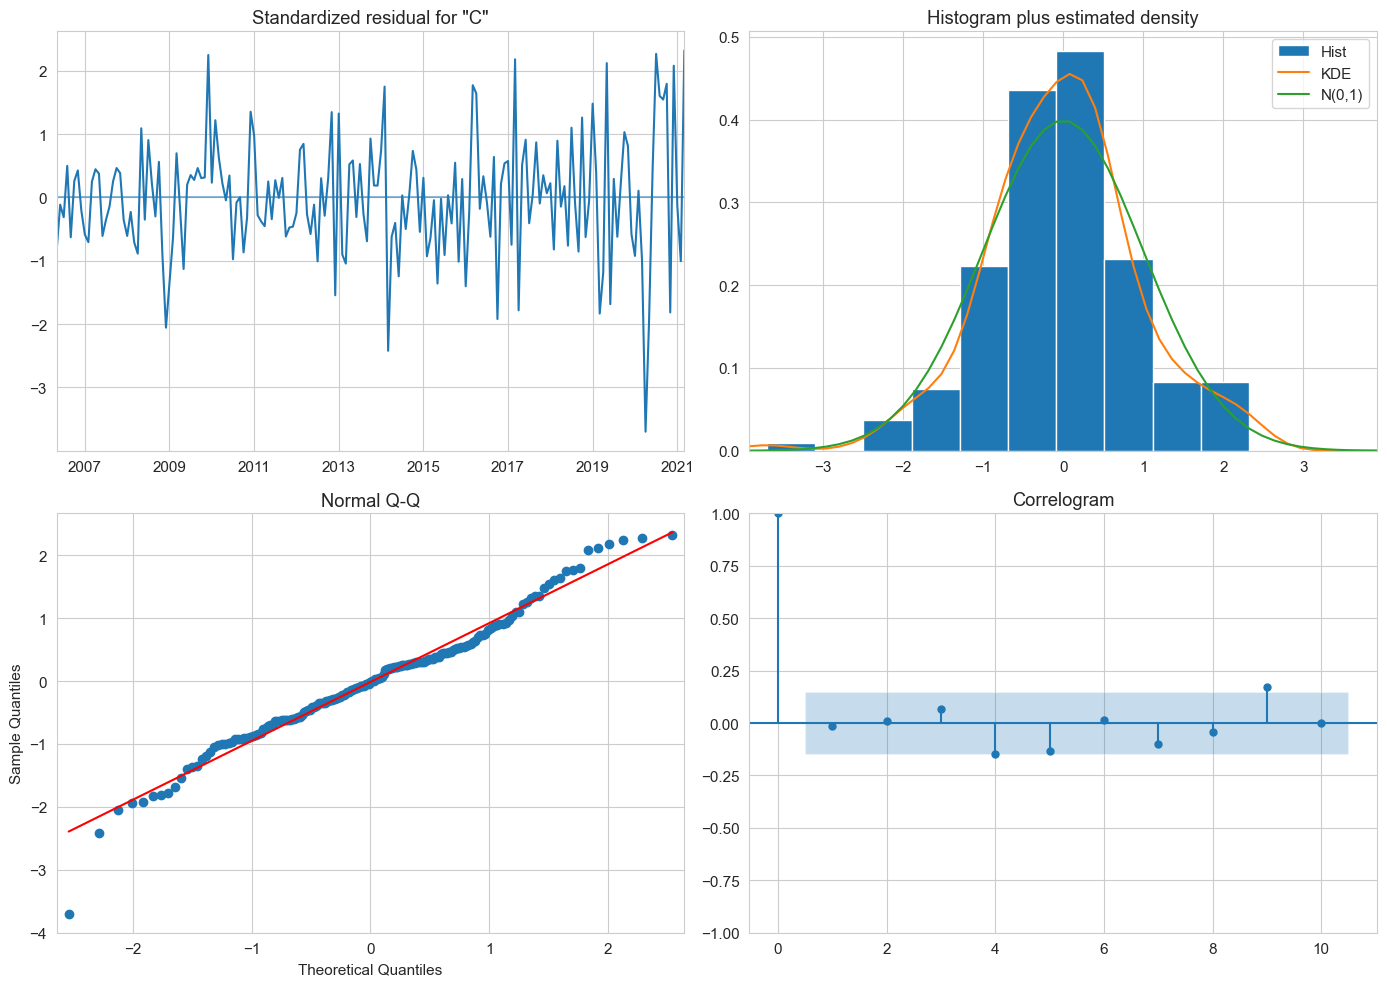

In [35]:
fig = sarima_fit.plot_diagnostics(figsize=(14, 10))
plt.tight_layout()
plt.show()

## 7. Modelagem Holt-Winters

O método de suavização exponencial tripla (Holt-Winters) captura nível, tendência e sazonalidade.

**Forma Aditiva:**
$$L_t = \alpha(y_t - S_{t-s}) + (1 - \alpha)(L_{t-1} + T_{t-1})$$
$$T_t = \beta(L_t - L_{t-1}) + (1 - \beta)T_{t-1}$$
$$S_t = \gamma(y_t - L_t) + (1 - \gamma)S_{t-s}$$
$$\hat{y}_{t+h} = L_t + hT_t + S_{t-s+h}$$

**Forma Multiplicativa:**
$$L_t = \alpha\frac{y_t}{S_{t-s}} + (1 - \alpha)(L_{t-1} + T_{t-1})$$
$$S_t = \gamma\frac{y_t}{L_t} + (1 - \gamma)S_{t-s}$$
$$\hat{y}_{t+h} = (L_t + hT_t) \times S_{t-s+h}$$

Onde $\alpha$, $\beta$ e $\gamma$ são os parâmetros de suavização ($0 \leq \alpha, \beta, \gamma \leq 1$).

In [36]:
# Modelo Holt-Winters Aditivo
hw_add = ExponentialSmoothing(
    treino, 
    seasonal_periods=12, 
    trend='add', 
    seasonal='add',
    initialization_method='estimated'
).fit(optimized=True)

print("Holt-Winters Aditivo")
print(f"alpha: {hw_add.params['smoothing_level']:.4f}")
print(f"beta:  {hw_add.params['smoothing_trend']:.4f}")
print(f"gamma: {hw_add.params['smoothing_seasonal']:.4f}")
print(f"AIC: {hw_add.aic:.2f}")

Holt-Winters Aditivo
alpha: 0.8065
beta:  0.0000
gamma: 0.1935
AIC: 5598.37


c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [37]:
# Modelo Holt-Winters Multiplicativo
hw_mult = ExponentialSmoothing(
    treino, 
    seasonal_periods=12, 
    trend='add', 
    seasonal='mul',
    initialization_method='estimated'
).fit(optimized=True)

print("Holt-Winters Multiplicativo")
print(f"alpha: {hw_mult.params['smoothing_level']:.4f}")
print(f"beta:  {hw_mult.params['smoothing_trend']:.4f}")
print(f"gamma: {hw_mult.params['smoothing_seasonal']:.4f}")
print(f"AIC: {hw_mult.aic:.2f}")

Holt-Winters Multiplicativo
alpha: 0.8264
beta:  0.0000
gamma: 0.1359
AIC: 5583.41


c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [38]:
# Seleção do melhor modelo Holt-Winters
comparacao_hw = pd.DataFrame({
    'Modelo': ['Aditivo', 'Multiplicativo'],
    'AIC': [hw_add.aic, hw_mult.aic],
    'BIC': [hw_add.bic, hw_mult.bic]
})
display(comparacao_hw)

if hw_add.aic < hw_mult.aic:
    hw_best = hw_add
    hw_tipo = "Aditivo"
else:
    hw_best = hw_mult
    hw_tipo = "Multiplicativo"

print(f"\nModelo selecionado: Holt-Winters {hw_tipo}")

,Modelo,AIC,BIC
0,Aditivo,5598.371006,5651.694506
1,Multiplicativo,5583.407725,5636.731225



Modelo selecionado: Holt-Winters Multiplicativo


## 8. Avaliação Comparativa dos Modelos

As métricas de avaliação utilizadas são:

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

$$MAPE = \frac{100\%}{n}\sum_{i=1}^{n}\left|\frac{y_i - \hat{y}_i}{y_i}\right|$$

In [39]:
# Previsões no conjunto de teste
pred_sarima = sarima_fit.forecast(steps=len(teste))
pred_sarima.index = teste.index

pred_hw = hw_best.forecast(steps=len(teste))
pred_hw.index = teste.index

In [40]:
# Cálculo das métricas
def calcular_metricas(real, previsto):
    rmse = np.sqrt(mean_squared_error(real, previsto))
    mae = mean_absolute_error(real, previsto)
    mape = np.mean(np.abs((real - previsto) / real)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape}

metricas_sarima = calcular_metricas(teste, pred_sarima)
metricas_hw = calcular_metricas(teste, pred_hw)

# Tabela comparativa
tabela_metricas = pd.DataFrame({
    f'SARIMA{best_params}': metricas_sarima,
    f'Holt-Winters ({hw_tipo})': metricas_hw
}).T

tabela_metricas

,RMSE,MAE,MAPE (%)
"SARIMA(0, 1, 2)",1.432770e+06,1.099728e+06,2.490276
Holt-Winters (Multiplicativo),1.354679e+06,1.086647e+06,2.514564


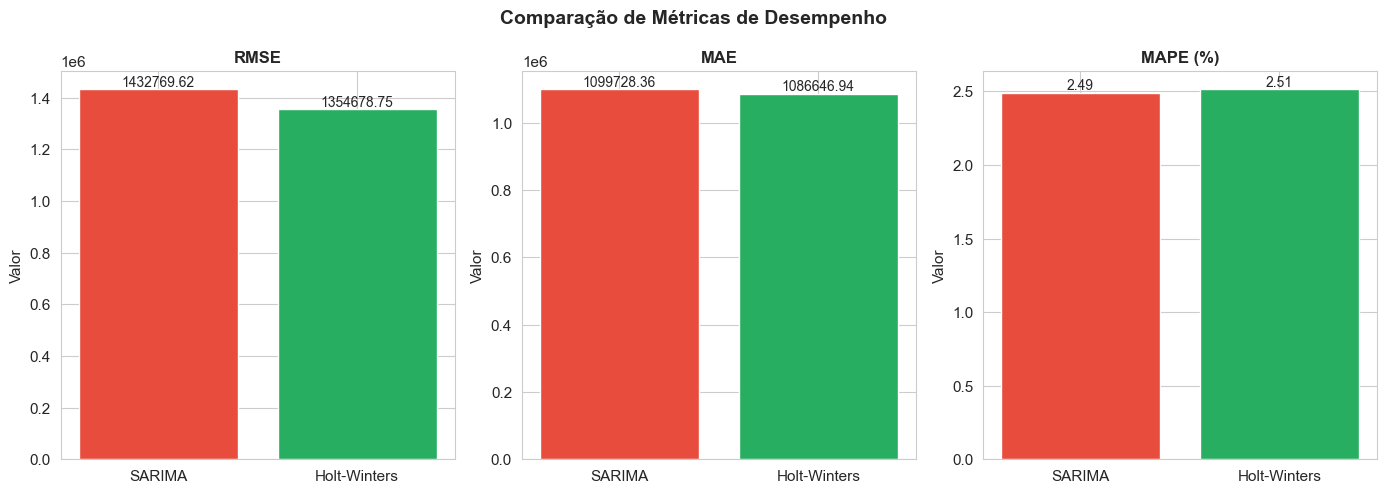

In [41]:
# Gráfico comparativo das métricas
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

metricas = ['RMSE', 'MAE', 'MAPE (%)']
cores = ['#e74c3c', '#27ae60']

for i, metrica in enumerate(metricas):
    valores = [metricas_sarima[metrica], metricas_hw[metrica]]
    barras = axes[i].bar(['SARIMA', 'Holt-Winters'], valores, color=cores)
    axes[i].set_title(metrica, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Valor')
    
    for barra, valor in zip(barras, valores):
        altura = barra.get_height()
        axes[i].text(barra.get_x() + barra.get_width()/2., altura,
                    f'{valor:.2f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparação de Métricas de Desempenho', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

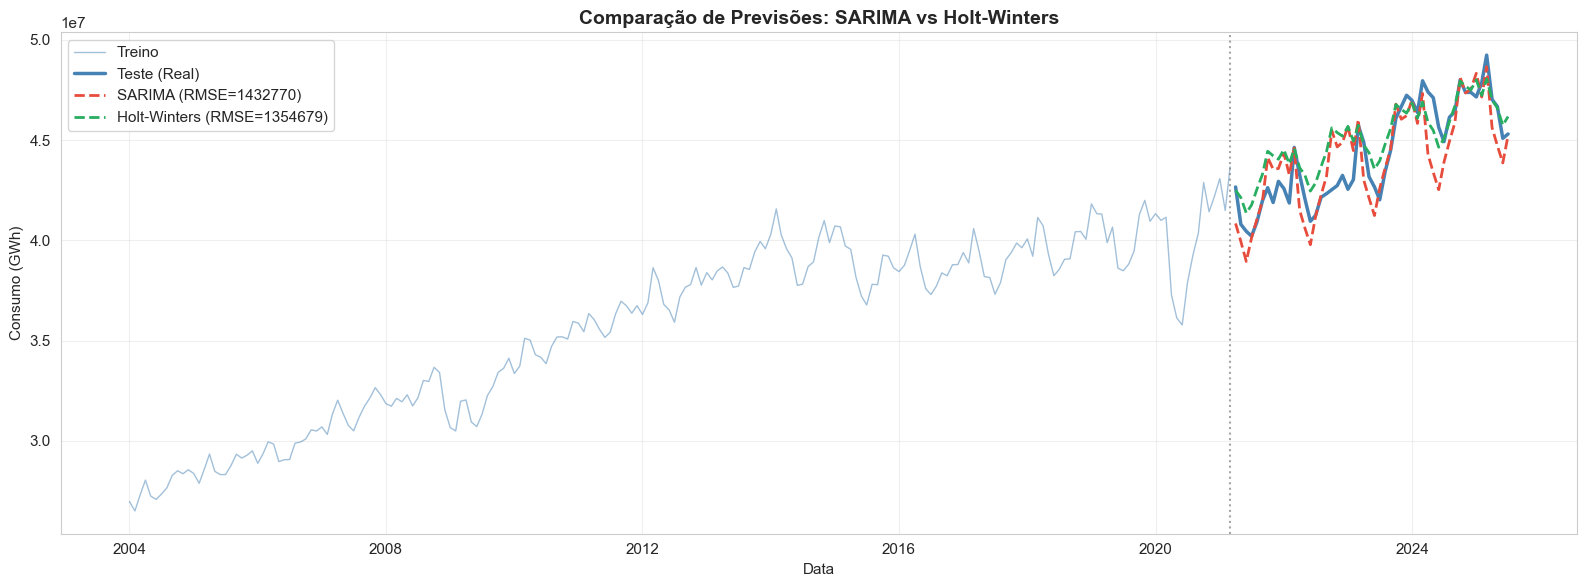

In [42]:
# Visualização: Previsões vs Dados Reais
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(treino.index, treino.values, color='steelblue', alpha=0.5, linewidth=1, label='Treino')
ax.plot(teste.index, teste.values, color='steelblue', linewidth=2.5, label='Teste (Real)')
ax.plot(pred_sarima.index, pred_sarima.values, color='#e74c3c', linewidth=2, 
        linestyle='--', label=f'SARIMA (RMSE={metricas_sarima["RMSE"]:.0f})')
ax.plot(pred_hw.index, pred_hw.values, color='#27ae60', linewidth=2, 
        linestyle='--', label=f'Holt-Winters (RMSE={metricas_hw["RMSE"]:.0f})')

ax.axvline(x=treino.index[-1], color='gray', linestyle=':', alpha=0.7)
ax.set_title('Comparação de Previsões: SARIMA vs Holt-Winters', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Consumo (GWh)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Previsões Futuras

Os modelos são reajustados com a série completa para gerar previsões para os próximos 12 meses.

In [43]:
# Reajuste com dados completos
meses_previsao = 12

sarima_full = SARIMAX(ts_total, order=best_params, seasonal_order=best_seasonal,
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
forecast_sarima = sarima_full.get_forecast(steps=meses_previsao)
pred_sarima_future = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

hw_full = ExponentialSmoothing(ts_total, seasonal_periods=12, trend='add',
                               seasonal='add' if hw_tipo == 'Aditivo' else 'mul',
                               initialization_method='estimated').fit(optimized=True)
pred_hw_future = hw_full.forecast(steps=meses_previsao)

indice_futuro = pd.date_range(start=ts_total.index[-1], periods=meses_previsao+1, freq='MS')[1:]

c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas Mazagão\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [45]:
# Tabela de previsões futuras
tabela_previsoes = pd.DataFrame({
    'Período': indice_futuro.strftime('%b/%Y'),
    'SARIMA': pred_sarima_future.values,
    'IC 95% Inferior': conf_int.iloc[:, 0].values,
    'IC 95% Superior': conf_int.iloc[:, 1].values,
    'Holt-Winters': pred_hw_future.values
})

# Formatar valores numéricos
for col in ['SARIMA', 'IC 95% Inferior', 'IC 95% Superior', 'Holt-Winters']:
    tabela_previsoes[col] = tabela_previsoes[col].apply(lambda x: f'{x:,.0f}')

tabela_previsoes

,Período,SARIMA,IC 95% Inferior,IC 95% Superior,Holt-Winters
0,ago/2025,"46,655,161","45,036,228","48,274,094","46,332,258"
1,set/2025,"46,998,433","44,823,105","49,173,761","46,938,581"
2,out/2025,"48,470,328","46,048,301","50,892,355","47,913,447"
3,nov/2025,"48,292,523","45,646,701","50,938,346","48,041,161"
4,dez/2025,"48,531,986","45,679,874","51,384,097","47,948,125"
5,jan/2026,"48,264,015","45,219,560","51,308,469","48,066,757"
6,fev/2026,"48,498,495","45,273,148","51,723,842","47,874,629"
7,mar/2026,"50,070,140","46,673,520","53,466,760","49,167,462"
8,abr/2026,"48,510,790","44,951,128","52,070,451","48,382,512"
9,mai/2026,"48,049,811","44,334,256","51,765,367","47,319,026"


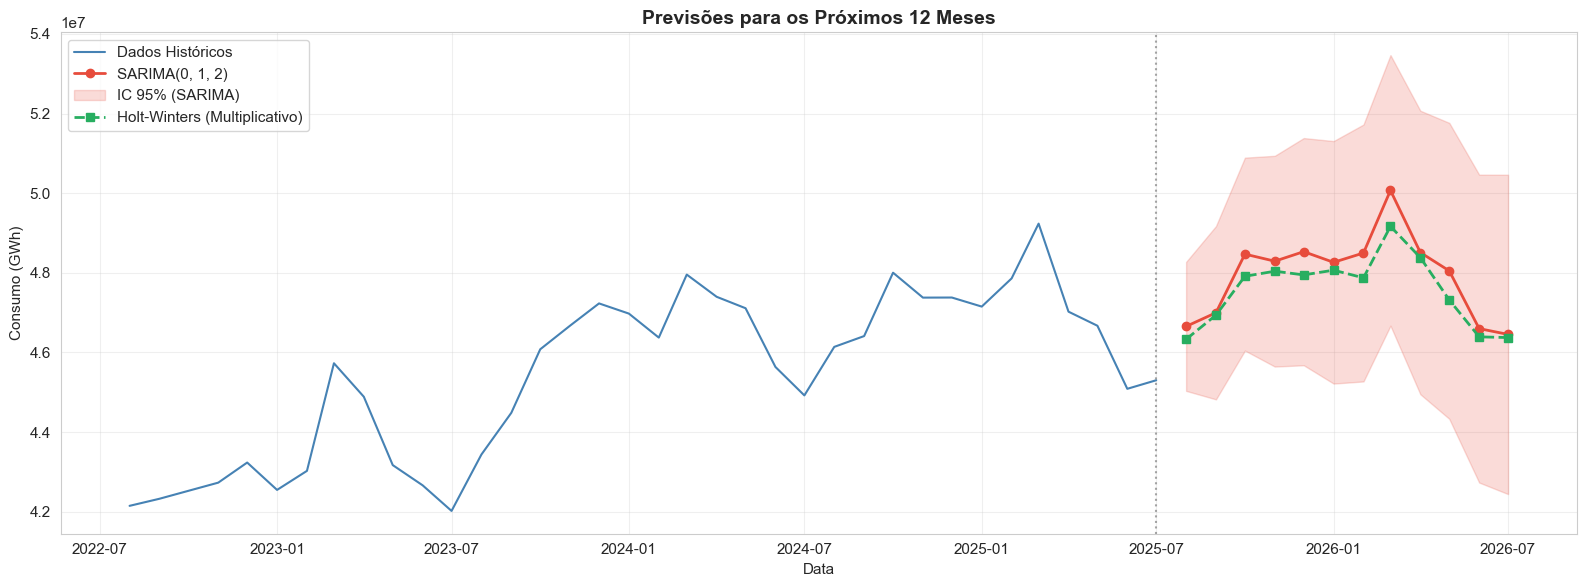

In [46]:
# Visualização das previsões futuras
fig, ax = plt.subplots(figsize=(16, 6))

ultimos_anos = ts_total[-36:]
ax.plot(ultimos_anos.index, ultimos_anos.values, color='steelblue', linewidth=1.5, label='Dados Históricos')

ax.plot(indice_futuro, pred_sarima_future.values, color='#e74c3c', linewidth=2, 
        marker='o', label=f'SARIMA{best_params}')
ax.fill_between(indice_futuro, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values,
                alpha=0.2, color='#e74c3c', label='IC 95% (SARIMA)')

ax.plot(indice_futuro, pred_hw_future.values, color='#27ae60', linewidth=2, 
        marker='s', linestyle='--', label=f'Holt-Winters ({hw_tipo})')

ax.axvline(x=ts_total.index[-1], color='gray', linestyle=':', alpha=0.7)
ax.set_title(f'Previsões para os Próximos {meses_previsao} Meses', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Consumo (GWh)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Análise de Resíduos

A análise de resíduos verifica a adequação dos modelos ajustados, avaliando:
- Normalidade (teste Shapiro-Wilk)
- Ausência de autocorrelação (ACF dos resíduos)
- Homocedasticidade

SARIMA - Teste Shapiro-Wilk: W=0.3585, p-valor=0.0000


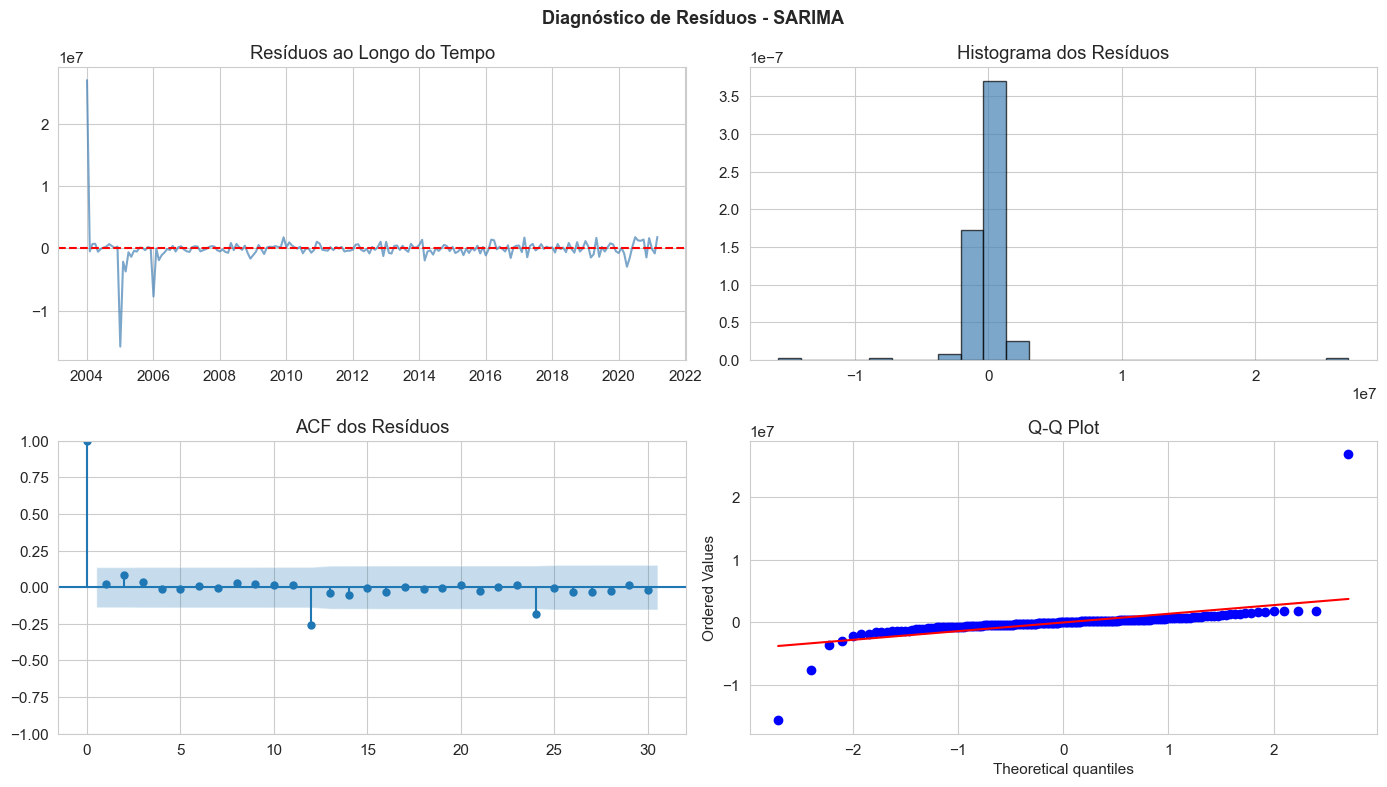

In [47]:
# Análise de Resíduos - SARIMA
residuos_sarima = sarima_fit.resid

stat, p_valor = stats.shapiro(residuos_sarima[:500] if len(residuos_sarima) > 500 else residuos_sarima)
print(f"SARIMA - Teste Shapiro-Wilk: W={stat:.4f}, p-valor={p_valor:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Diagnóstico de Resíduos - SARIMA', fontsize=13, fontweight='bold')

axes[0, 0].plot(residuos_sarima, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Resíduos ao Longo do Tempo')

axes[0, 1].hist(residuos_sarima, bins=25, edgecolor='black', density=True, alpha=0.7, color='steelblue')
axes[0, 1].set_title('Histograma dos Resíduos')

plot_acf(residuos_sarima, lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF dos Resíduos')

stats.probplot(residuos_sarima, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

Holt-Winters - Teste Shapiro-Wilk: W=0.9585, p-valor=0.0000


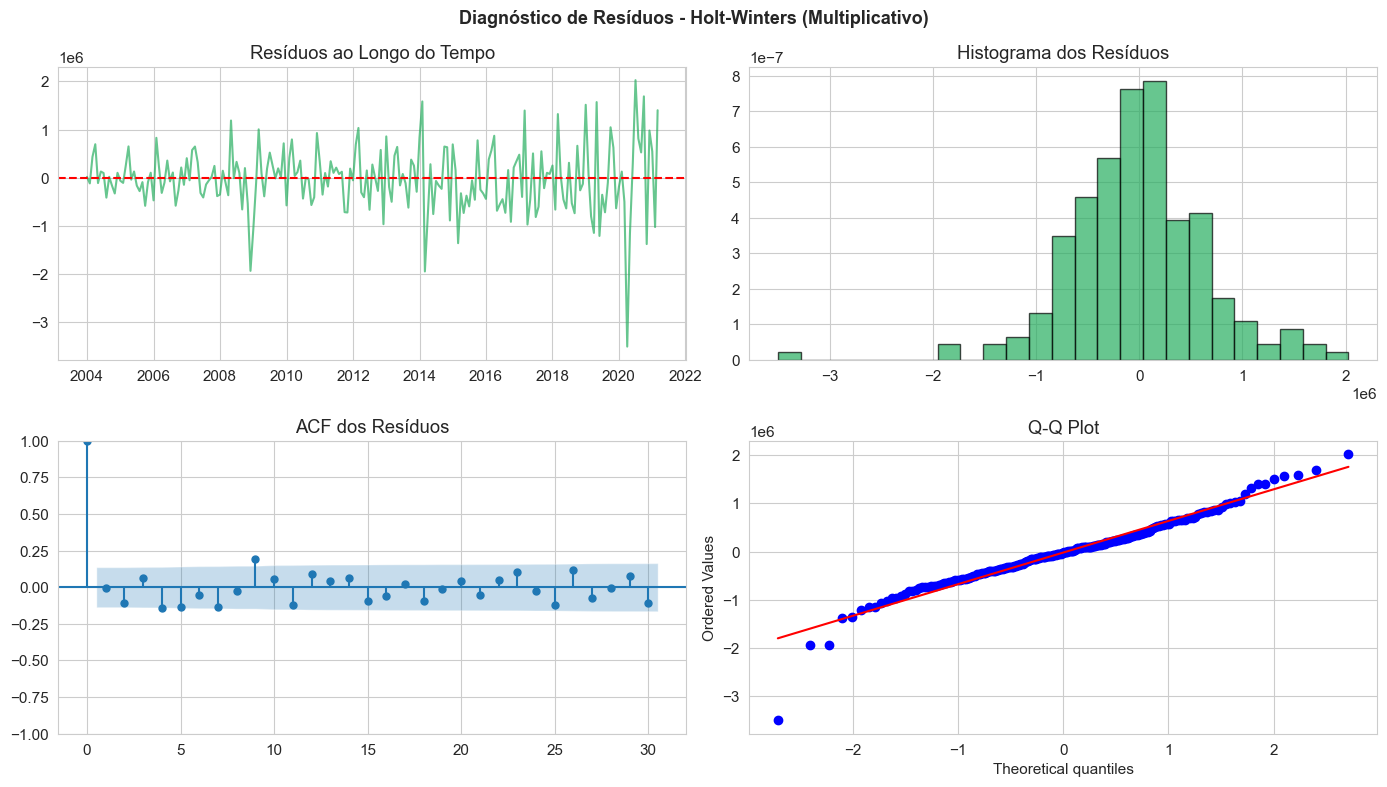

In [48]:
# Análise de Resíduos - Holt-Winters
residuos_hw = hw_best.resid

stat, p_valor = stats.shapiro(residuos_hw[:500] if len(residuos_hw) > 500 else residuos_hw)
print(f"Holt-Winters - Teste Shapiro-Wilk: W={stat:.4f}, p-valor={p_valor:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle(f'Diagnóstico de Resíduos - Holt-Winters ({hw_tipo})', fontsize=13, fontweight='bold')

axes[0, 0].plot(residuos_hw, color='#27ae60', alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Resíduos ao Longo do Tempo')

axes[0, 1].hist(residuos_hw, bins=25, edgecolor='black', density=True, alpha=0.7, color='#27ae60')
axes[0, 1].set_title('Histograma dos Resíduos')

plot_acf(residuos_hw, lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF dos Resíduos')

stats.probplot(residuos_hw, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

## 11. Conclusões

Este estudo comparou os modelos SARIMA e Holt-Winters para previsão de séries temporais aplicados aos dados de consumo residencial de energia elétrica no Brasil.

In [49]:
# Resumo comparativo
resumo = pd.DataFrame({
    'Aspecto': ['Modelo', 'RMSE', 'MAE', 'MAPE (%)', 'Tendência', 'Sazonalidade'],
    'SARIMA': [f'{best_params}{best_seasonal}', 
               f'{metricas_sarima["RMSE"]:,.2f}',
               f'{metricas_sarima["MAE"]:,.2f}',
               f'{metricas_sarima["MAPE (%)"]:.2f}',
               'Capturada', 'Capturada'],
    'Holt-Winters': [hw_tipo,
                     f'{metricas_hw["RMSE"]:,.2f}',
                     f'{metricas_hw["MAE"]:,.2f}',
                     f'{metricas_hw["MAPE (%)"]:.2f}',
                     'Capturada', 'Capturada']
})

display(resumo.set_index('Aspecto'))

# Identificação do melhor modelo
vencedor = "SARIMA" if metricas_sarima['RMSE'] < metricas_hw['RMSE'] else "Holt-Winters"
diff_rmse = abs(metricas_sarima['RMSE'] - metricas_hw['RMSE'])

print(f"\nModelo com melhor desempenho: {vencedor}")
print(f"Diferença de RMSE: {diff_rmse:,.2f}")

,SARIMA,Holt-Winters
Aspecto,,
Modelo,"(0, 1, 2)(1, 1, 1, 12)",Multiplicativo
RMSE,"1,432,769.62","1,354,678.75"
MAE,"1,099,728.36","1,086,646.94"
MAPE (%),2.49,2.51
Tendência,Capturada,Capturada
Sazonalidade,Capturada,Capturada



Modelo com melhor desempenho: Holt-Winters
Diferença de RMSE: 78,090.87
